# Machine Learning to Predict Costs and Evaluate Geographic Disparities

##### Load the cleaned / new data set

In [1]:
#Load the cleaned dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("cleaned_childcare_data.csv")

##### Prepare the data. Pull out and group the different age groups. Remove punctuation and reduce the "price" column to numbers only.

In [2]:
#Prep the data set
df_melted = df.melt(
    id_vars=['StudyYear'],
    value_vars=[
        '_75FCCInfant', '_75FCCToddler', '_75FCCPreschool',
        '_75CInfant', '_75CToddler', '_75CPreschool'
    ],
    var_name='care_age',
    value_name='price'
)

# Extract care type and age group
df_melted['care_type'] = df_melted['care_age'].apply(
    lambda x: 'in-home' if 'FCC' in x else 'center'
)
df_melted['age_group'] = df_melted['care_age'].str.extract(r'(Infant|Toddler|Preschool)')

df_melted['price'] = (
    df_melted['price']
    .astype(str)                             
    .str.replace(r'[\$,]', '', regex=True)   
    .str.replace(r'\s+', '', regex=True)     
    .replace('', np.nan)                    
    .astype(float)                          
)
print(df_melted['price'].isna().sum())
print(df_melted.shape)

# Group by year and care_type to get average
avg_prices = df_melted.groupby(['StudyYear', 'care_type'])['price'].mean().reset_index()

print(df_melted['price'].describe())


0
(72270, 5)
count    72270.000000
mean       143.957952
std         50.323744
min         46.450000
25%        111.252500
50%        131.580000
75%        163.295000
max        515.000000
Name: price, dtype: float64


##### Find the top states with the most expensive weekly childcare costs, on average. This is a combination of both types of care. 

In [3]:
# Find the state with the most expensive child care on average
# Melt data frame
df_melted = df.melt(
    id_vars=['State_Name', 'StudyYear'],
    value_vars=[
        '_75FCCInfant', '_75FCCToddler', '_75FCCPreschool',
        '_75CInfant', '_75CToddler', '_75CPreschool'
    ],
    var_name='care_age',
    value_name='price'
)

# 2. Clean the price column
df_melted['price'] = (
    df_melted['price']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .str.replace(r'\s+', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

# 3. Group by State and calculate average price
avg_price_by_state = df_melted.groupby('State_Name')['price'].mean().reset_index()

# 4. Sort to find the most expensive
top_states = avg_price_by_state.sort_values(by='price', ascending=False)

##### Now, split the most expensive states based on which type of care. 

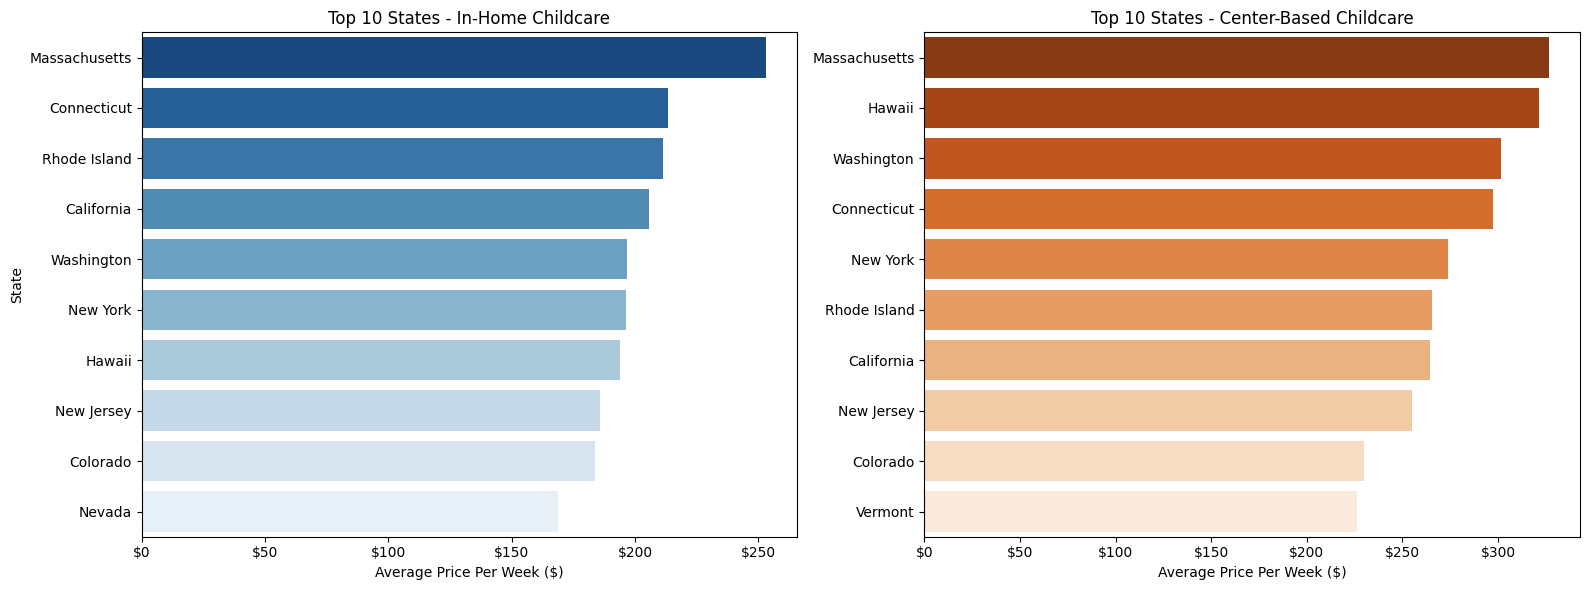

In [4]:
# Display states with most expensive childcare but differentiate between type of care
import matplotlib.ticker as mtick

# 1. Melt the dataframe
df_melted = df.melt(
    id_vars=['State_Name', 'StudyYear'],
    value_vars=[
        '_75FCCInfant', '_75FCCToddler', '_75FCCPreschool',
        '_75CInfant', '_75CToddler', '_75CPreschool'
    ],
    var_name='care_age',
    value_name='price'
)

# 2. Extract care type
df_melted['care_type'] = df_melted['care_age'].apply(
    lambda x: 'in-home' if 'FCC' in x else 'center'
)

# 3. Clean the price column
df_melted['price'] = (
    df_melted['price']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .str.replace(r'\s+', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

# 4. Group by state and care type, then compute average price
avg_price_by_state_type = df_melted.groupby(['State_Name', 'care_type'])['price'].mean().reset_index()

# 5. Get top 10 for each care type
top10_inhome = avg_price_by_state_type[avg_price_by_state_type['care_type'] == 'in-home'] \
    .sort_values(by='price', ascending=False).head(10)

top10_center = avg_price_by_state_type[avg_price_by_state_type['care_type'] == 'center'] \
    .sort_values(by='price', ascending=False).head(10)

# 6. Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

# In-home
sns.barplot(data=top10_inhome, x='price', y='State_Name', hue= 'State_Name', palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 States - In-Home Childcare')
axes[0].set_xlabel('Average Price Per Week ($)')
axes[0].set_ylabel('State')
axes[0].xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Center-based
sns.barplot(data=top10_center, x='price', y='State_Name', hue= 'State_Name', palette='Oranges_r', ax=axes[1], legend=False)
axes[1].set_title('Top 10 States - Center-Based Childcare')
axes[1].set_xlabel('Average Price Per Week ($)')
axes[1].set_ylabel('')  # Don't repeat label
axes[1].xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
plt.show()

##### Create, train, and test a linear regression model to predict childcare costs. 

In [5]:
# Create a linear regression model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Drop rows with missing prices
df_ml = df_melted.dropna(subset=['price'])

# One-hot encode categorical features
df_encoded = pd.get_dummies(df_ml[['State_Name', 'StudyYear', 'care_type', 'care_age']], drop_first=True)

# Define features (X) and target (y)
X = df_encoded
y = df_ml['price']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
#Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


##### Evaluate the model's overall performance

In [8]:
#Evaluate performance
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Square Error (RMSE): {rmse:.2f}") 

Root Mean Square Error (RMSE): 30.67


#### Compare its performance to other models to see if there is a better performing option.

In [16]:
#COmpare to other models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Dictionary to store models and their RMSEs
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'KNN': KNeighborsRegressor()
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = rmse
    print(f'{name} RMSE: {rmse:.2f}')

Linear Regression RMSE: 30.67
Decision Tree RMSE: 28.52
Random Forest RMSE: 28.51
Gradient Boosting RMSE: 32.11
KNN RMSE: 31.06


#### Put the model performance in to a visualization.

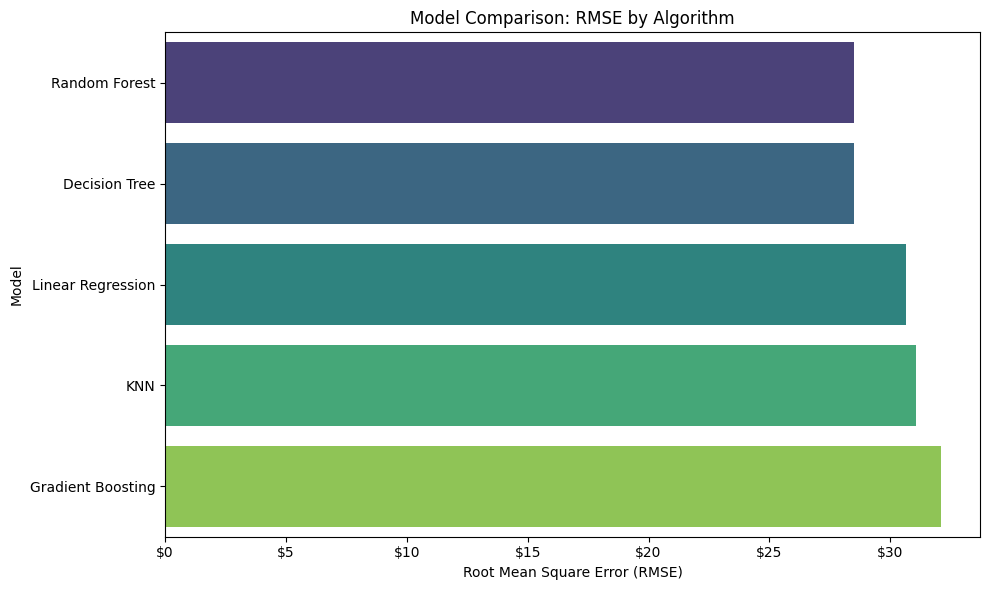

In [17]:
# Visualize model comparisons
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results dictionary to DataFrame
rmse_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE'])

# Sort models by RMSE (lower is better)
rmse_df = rmse_df.sort_values(by='RMSE')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=rmse_df, x='RMSE', y='Model', hue = 'Model', palette='viridis', legend= False)

plt.title('Model Comparison: RMSE by Algorithm')
plt.xlabel('Root Mean Square Error (RMSE)')
plt.ylabel('Model')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))  # Dollar formatting

plt.tight_layout()
plt.show()

#### The random forest model performed the best, so let's use that to make predictions. 

In [18]:
#Make predictions using random forest modeling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1. Drop missing values
df_ml = df_melted.dropna(subset=['price'])

# 2. One-hot encode categorical features
df_encoded = pd.get_dummies(df_ml[['State_Name', 'StudyYear', 'care_type', 'care_age']], drop_first=True)

# 3. Define features and target
X = df_encoded
y = df_ml['price']

# 4. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 6. Predict on the test set
y_pred = rf_model.predict(X_test)

# 7. Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest RMSE: {rmse:.2f}")


Random Forest RMSE: 28.51


#### Plot the predicted prices compared to the actual prices to visualize how well the model performed.

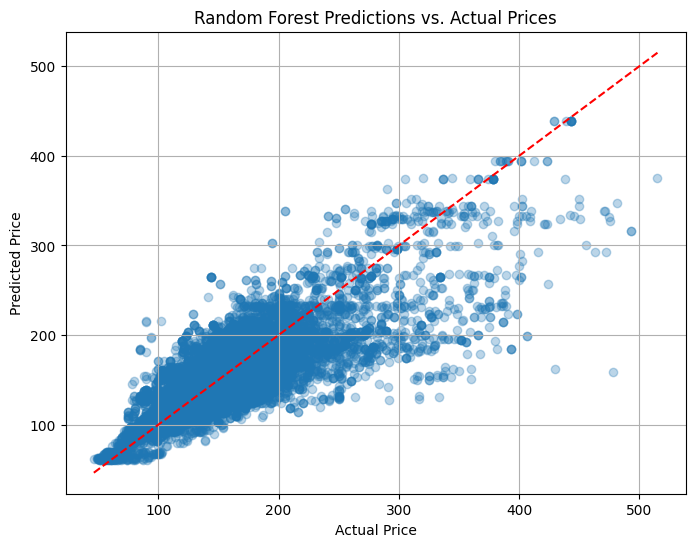

In [19]:
import matplotlib.pyplot as plt

# Plot predicted vs. actual prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest Predictions vs. Actual Prices")
plt.grid(True)
plt.show()


#### Create a chloropleth to help visualize which states/regions have the most expensive childcare costs. 

In [20]:
#Create map to show geographic disparity
import plotly.express as px

# Aggregate to average price per state
df_state_avg = df_melted.groupby('State_Name', as_index=False)['price'].mean()

# Add a state abbreviation column if needed
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

df_state_avg['StateCode'] = df_state_avg['State_Name'].map(state_abbrev)

# Create choropleth
fig = px.choropleth(
    df_state_avg,
    locations='StateCode',
    locationmode='USA-states',
    color='price',
    scope='usa',
    color_continuous_scale='Reds',
    labels={'price': 'Avg Price ($)'},
    title='Average Child Care Prices by State'
)
fig.show()

#### Check to see what the prediction errors score is. Create a visualization for that. 

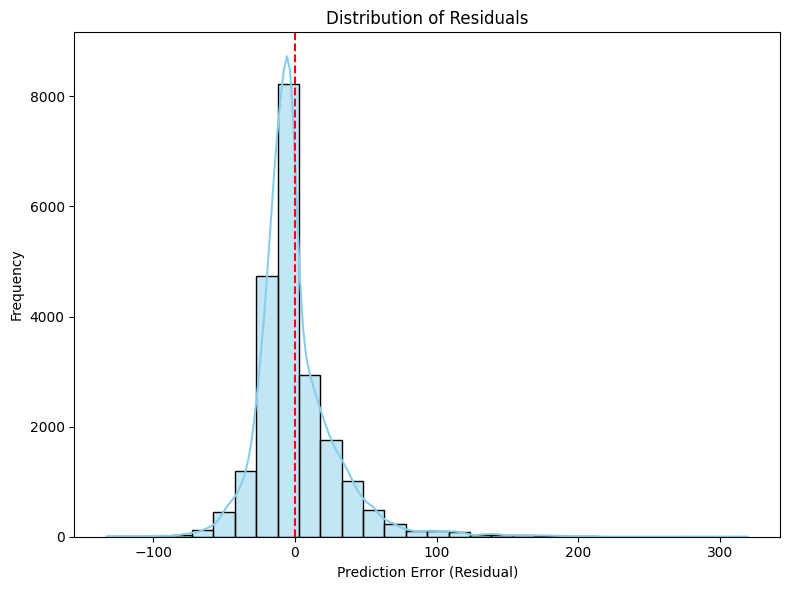

In [21]:
# Check for model bias
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color="skyblue")
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

##### Create a chart to display the predicted costs of childcare in each state. The types of childcare are combined. It's an overall look at which states are most expensive. 

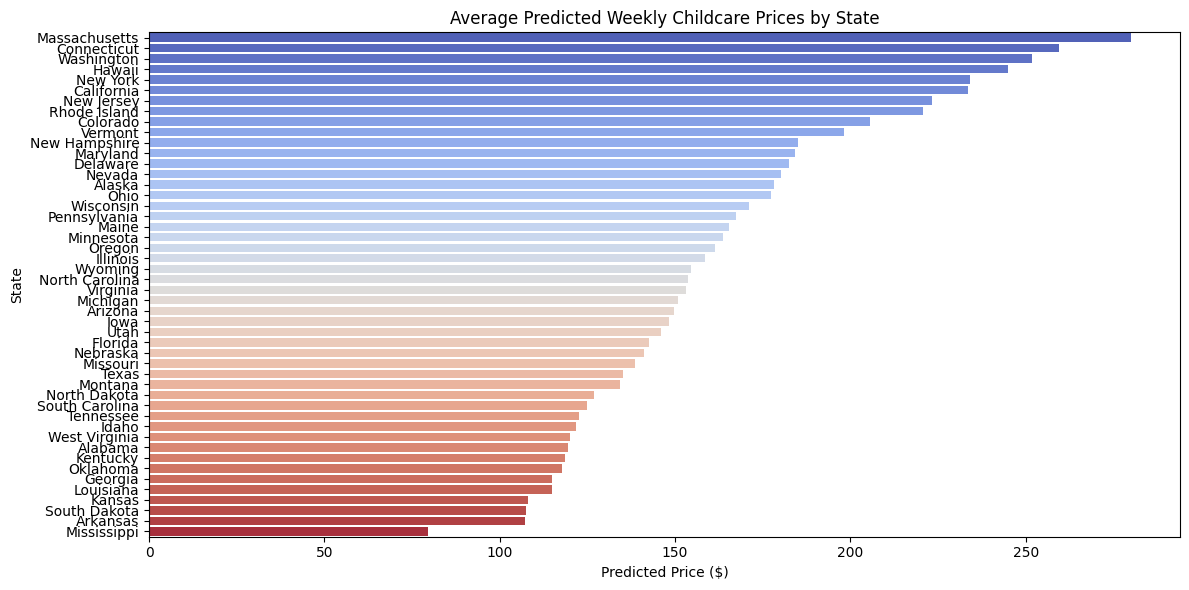

In [22]:
df_test = df_ml.iloc[y_test.index].copy()
df_test['Predicted_Price'] = y_pred

# Group by state to get average predicted prices
avg_state_prices = df_test.groupby('State_Name')['Predicted_Price'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_state_prices.sort_values('Predicted_Price', ascending=False),
            x='Predicted_Price', y='State_Name', hue= "State_Name", palette='coolwarm', legend = False)
plt.title("Average Predicted Weekly Childcare Prices by State")
plt.xlabel("Predicted Price ($)")
plt.ylabel("State")
plt.tight_layout()
plt.show()